In [28]:
import pandas as pd, numpy as np
np.set_printoptions(suppress=True)# 关掉科学计数法
import glob
import os
import csv
# 一次性merge多个pct_chg
from functools import reduce
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels import regression

# import yfinance as yf
import tushare as ts
import time, urllib
ts.set_token('8ef5ec61cdd848715c57c11d58dd71da1271f76b2420d2bac8aef123')

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=False, rc=None)

from plotly.graph_objs import Scatter,Layout
import plotly
import plotly.offline as py
import numpy as np
import plotly.graph_objs as go

#setting offilne
plotly.offline.init_notebook_mode(connected=True)

# Paramater Settings

In [2]:
etf_path = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/"

# Mannually check our current position holdings for potential exit signals:
cur_positions = [
    '159916',
#     '159918',
#     '159932',
    '159933',
#     '159938',
#     '159951',
    '510090',
    '510110',
    '510270',
#     '510580',
    '511030',
#     '512010',
#     '512290',
#     '512560',
    "512590"
#     '518880'
]
len(cur_positions)

date = [
    "2020-01-02",
    "2020-01-03",
    "2020-01-06",
    "2020-01-07",
    "2020-01-08",
    "2020-01-09",
    "2020-01-10",
    "2020-01-13",
    "2020-01-14",
    "2020-01-15",
    "2020-01-16",
    "2020-01-17",
    "2020-01-20",
    "2020-01-21",
    "2020-01-22",
    "2020-01-23",
    "2020-02-03",
    "2020-02-04",
    "2020-02-05",
    "2020-02-06",
    "2020-02-07",
    "2020-02-10",
    "2020-02-11",
    "2020-02-12",
    "2020-02-13",
    "2020-02-14",
    "2020-02-17",
    "2020-02-18",
    "2020-02-19",
    "2020-02-20",
    "2020-02-21",
    "2020-02-24",
    "2020-02-25",
    "2020-02-26",
    "2020-02-27",
    "2020-02-28",
    "2020-03-02",
    "2020-03-03",
    "2020-03-04",
    "2020-03-05"
]
sbtv1 = [0+1,#1/2
        0+1,
        0+1,
        0+1,
        -0.005/100+1,
        -0.001/100+1,
        0.01/100+1,
        0.01/100+1,
        0.03/100+1,
        0.02/100+1,
        -0.03/100+1,
        0.06/100+1,
        0.07/100+1,
        0.13/100+1,
        0.0795/100+1,
        0.2/100+1,
        0.68136/100+1,
         710/200000+1,#2/4
         824.42/200000+1,#2/5
         654.42/200000+1,#2/6
         745.42/200000+1,#2/7
         833/200000+1,#2/8
         933/200000+1,#2/11
         911/200000+1,
         676.53/200000+1,
         882.52/200000+1,
         1813.76/200000+1,
         2210.96/200000+1,
         1947.66/200000+1,
         2553.70/200000+1,
         2881.31/200000+1, #2020-02-21
         3423.72/200000+1,
         3239.46/200000+1,
         2397.44/200000+1,
         2379.78/200000+1,
         1123.98/200000+1,
         1767.30/200000+1,
         1793.10/200000+1,
         1778.17/200000+1,
         2182.02/200000+1
        ]

In [3]:
# Get ETF tickers from the summary data sheet
def get_all_etf_tickers_from_summary_file(etf_summary_file):
    ch_etfs_df = pd.read_csv(etf_summary_file, engine="python")
    ch_etfs_df['code'] =ch_etfs_df['证券代码'].apply(lambda x: str(x)[:6])
    ch_etfs_ticker = list(ch_etfs_df['code'].unique())
    return ch_etfs_ticker

#=============================================================
# Get all market data columns as a dataframe from a folder
def get_mkt_data_df(path, ticker_list, date_col):
    # e.g. ch_db_path = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/"
    csv_path = path+"*.csv"
    files = glob.glob(csv_path)
    ticker_df_list = []
    for ticker in ticker_list:
        try:
            ticker_df = pd.read_csv(path+ticker+".csv")
            ticker_df = ticker_df.sort_values(date_col)
            ticker_df_list.append(ticker_df) 
        except Exception as e:
            print(e)
    try:
        tickers_data_concated = pd.concat(ticker_df_list)
        tickers_data_concated.reset_index(inplace=True)
        del tickers_data_concated['index']  
    except Exception as e:
        print(e)
    return tickers_data_concated

# Get date_col, price_col, code
def get_date_price_code_df(path, ticker_list, date_col, price_col, code_col):
    # for etf data cols are 'date', 'close', 'code'
    ticker_df_list = []
    for ticker in ticker_list:
        try:
            ticker_df = pd.read_csv(path+ticker+".csv")
            ticker_df = ticker_df.sort_values(date_col)
            ticker_df = ticker_df[[date_col, price_col, code_col]]
            ticker_df['code'] = ticker
            ticker_df_list.append(ticker_df)
        except Exception as e:
            print(e)
    try:
        tickers_data_concated = pd.concat(ticker_df_list)
        tickers_data_concated.reset_index(inplace=True)
        del tickers_data_concated['index']  
    except Exception as e:
        print(e)
    return tickers_data_concated

# Get date_col, price_col, code_col, pct_chg_col
def get_date_price_code_return_df(path, ticker_list, date_col, price_col, code_col):
    # for etf data cols are 'date', 'close', 'code'
    ticker_df_list = []
    for ticker in ticker_list:
        try:
            ticker_df = pd.read_csv(path+ticker+".csv")
            ticker_df = ticker_df.sort_values(date_col)
            ticker_df = ticker_df[[date_col, price_col, code_col]]
            ticker_df['pct_chg'] = ticker_df[price_col].pct_change()
            ticker_df = ticker_df[[date_col, 'pct_chg']].dropna()
            ticker_df['code'] = ticker
            ticker_df_list.append(ticker_df)
        except Exception as e:
            print(e)
    try:
        tickers_data_concated = pd.concat(ticker_df_list)
        tickers_data_concated.reset_index(inplace=True)
        del tickers_data_concated['index']  
    except Exception as e:
        print(e)
    return tickers_data_concated

# Get date_col, price_col, code_col, pct_chg_col
def get_date_price_code_cumreturns_df(path, ticker_list, date_col, price_col, code_col):
    # for etf data cols are 'date', 'close', 'code'
    ticker_df_list = []
    for ticker in ticker_list:
        try:
            ticker_df = pd.read_csv(path+ticker+".csv")
            ticker_df = ticker_df.sort_values(date_col)
            ticker_df = ticker_df[[date_col, price_col, code_col]]
            ticker_df['pct_chg'] = ticker_df[price_col].pct_change()
            ticker_df['cum_returns'] = ticker_df['pct_chg'].cumsum()+1
            ticker_df = ticker_df[[date_col, 'cum_returns']].dropna()
            ticker_df['code'] = ticker
            ticker_df_list.append(ticker_df)
        except:
            pass
    try:
        tickers_data_concated = pd.concat(ticker_df_list)
    except Exception as e:
        print(e)
    return tickers_data_concated

#=============================================================

# Get all market data columns as a dataframe from a folder
def get_mkt_data_list(path, ticker_list, date_col):
    # e.g. ch_db_path = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/"
    csv_path = path+"*.csv"
    files = glob.glob(csv_path)
    ticker_df_list = []
    for ticker in ticker_list:
        try:
            ticker_df = pd.read_csv(path+ticker+".csv")
            ticker_df = ticker_df.sort_values(date_col)
            ticker_df_list.append(ticker_df) 
        except Exception as e:
            print(e)
    return ticker_df_list

# Get date_col, price_col, code
def get_date_price_code_list(path, ticker_list, date_col, price_col, code_col):
    # for etf data cols are 'date', 'close', 'code'
    ticker_df_list = []
    for ticker in ticker_list:
        try:
            ticker_df = pd.read_csv(path+ticker+".csv")
            ticker_df = ticker_df.sort_values(date_col)
            ticker_df = ticker_df[[date_col, price_col]]
            ticker_df.columns = [date_col, ticker]
            ticker_df_list.append(ticker_df)
        except Exception as e:
            print(e)
    return ticker_df_list

# Get date_col, price_col, code_col, pct_chg_col
def get_date_price_code_return_list(path, ticker_list, date_col, price_col, code_col):
    # for etf data cols are 'date', 'close', 'code'
    ticker_df_list = []
    for ticker in ticker_list:
        try:
            ticker_df = pd.read_csv(path+ticker+".csv")
            ticker_df = ticker_df.sort_values(date_col)
            ticker_df = ticker_df[[date_col, price_col, code_col]]
            ticker_df['pct_chg'] = ticker_df[price_col].pct_change()
            ticker_df = ticker_df[[date_col, 'pct_chg']].dropna()
            ticker_df.columns = [date_col, ticker]
            ticker_df_list.append(ticker_df)
        except Exception as e:
            print(e)
    return ticker_df_list

# Get date_col, price_col, code_col, pct_chg_col
def get_date_price_code_cumreturns_list(path, ticker_list, date_col, price_col, code_col):
    # for etf data cols are 'date', 'close', 'code'
    ticker_df_list = []
    for ticker in ticker_list:
        try:
            ticker_df = pd.read_csv(path+ticker+".csv")
            ticker_df = ticker_df.sort_values(date_col)
            ticker_df = ticker_df[[date_col, price_col, code_col]]
            ticker_df['pct_chg'] = ticker_df[price_col].pct_change()
            ticker_df['cum_returns'] = ticker_df['pct_chg'].cumsum()+1
            ticker_df = ticker_df[[date_col, 'cum_returns']].dropna()
            ticker_df.columns = [date_col, ticker]
            ticker_df_list.append(ticker_df)
        except:
            pass
    return ticker_df_list

#=============================================================

def get_sector_leaders():
    etf_sectors = pd.read_csv("/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/ETF_板块已分类.csv")
#     etf_sectors.dropna(inplace=True)
    filtered_1 = etf_sectors[etf_sectors['所属板块']!=""]
    filtered_1.columns = ['ticker','name','type1','type2','mkt_cap','institution_holdings',
                          'ins_holding_pct','fee1%','fee2%','fee3%','sector']
    filtered_1['mkt_cap'] = filtered_1['mkt_cap'].apply(lambda x: x.replace(",","")).apply(lambda x: float(x))
    filtered_1.reset_index(inplace = True)
    del filtered_1['index']
    filtered_1['rank'] = filtered_1.groupby(['sector'])['mkt_cap'].rank(ascending = False)
    filtered_2 = filtered_1[filtered_1['rank']==1]
    filtered_2['code'] = filtered_2['ticker'].str.split(".", expand = True)[0]
    filtered_2['exchange'] = filtered_2['ticker'].str.split(".", expand = True)[1]
    filtered_2_tickers = list(filtered_2['code'].unique())
    return filtered_2_tickers




# merge df1 with df2
def merge_df_for_reduce(df1, df2, date_col="date"):
    # By default the etf's date_col goes by 'date'
    merged = df1.merge(df2, on = date_col, how = 'outer')
    merged.sort_values(date_col, inplace = True)
    return merged

# merge a list of dfs on date_col
def merge_dfs_by_ticker(ticker_df_list, date_col):
    merged_all = reduce(merge_df_for_reduce, ticker_df_list)
    merged_all.set_index(date_col, inplace=True)
    merged_all.dropna(how="all", axis = 1, inplace = True)
    merged_all.fillna(method="ffill", inplace = True)
    return merged_all


def MACD(df, n_fast, n_slow, n_macd, price_col): # n_fast = 12, n_slow = 26
    """
    http://stockcharts.com/docs/doku.php?id=scans:indicators
    MACD, MACD Signal and MACD difference, rationale CHECKED, code CHECKED, updated
    # Conventional look-back window for calculating MACDsign is 9
    """
    EMAfast = df[price_col].ewm(span = n_fast, min_periods = n_fast - 1).mean()
    EMAslow = df[price_col].ewm(span = n_slow, min_periods = n_slow - 1).mean()
    MACD = pd.Series(EMAfast - EMAslow, name = 'MACD_' + str(n_fast) + '_' + str(n_slow))
    MACDsign = MACD.ewm(span = n_macd, min_periods = n_macd-1).mean().rename('MACDsign_' + str(n_fast) + '_' + str(n_slow))
    MACDdiff = pd.Series(MACD - MACDsign, name = 'MACDdiff_' + str(n_fast) + '_' + str(n_slow))
    df['MACD_Diff'] = MACD
    df['MACD_Diff_EMA'] = MACDsign
    df['MACD'] = MACDdiff
    df['SIGNAL_STATUS'] = df['MACD'].apply(lambda x: "多头状态" if x>0 else ("空头状态" if x<0 else "无信号状态"))
    return df

def calc_macd_signals(tickers_data_concated, ticker_list, code_col, ticker_type, price_col):
    signal_record = []
    signal_data = []
    if len(ticker_list)!=1:
        for ticker in ticker_list:
            try:
                if ticker_type == "float":
                # Be aware of types of ticker values here, whether it's float or strings, depends.
                    single_ticker_df = tickers_data_concated[tickers_data_concated[code_col]==float(ticker)]
                elif ticker_type == "string":
                    single_ticker_df = tickers_data_concated[tickers_data_concated[code_col]==ticker]
                signal_df = MACD(single_ticker_df, 12, 26, 9, price_col)
#                 last_signal = signal_df[[code_col,'SIGNAL_STATUS']].values[-1]
                signal_data.append(signal_df)
#                 signal_record.append(last_signal)
            except:
                pass
        signal_data_df = pd.concat(signal_data)
    else:
        try:                
            signal_df = MACD(tickers_data_concated, 12, 26, 9, price_col)
        except:
            pass
        signal_data_df = signal_df
    return signal_data_df

def make_numeric_signals(series):
    for item in series:
        if item =="多":
            return 1
        elif item =="空":
            return -1
        else:
            return 0
        
def get_last_signals_macd(signal_data_df, date_col, code_col):
    # v1 is the version of generating the og macd signals
    signal_data_df['SIGNAL_DIRECTION'] = signal_data_df['SIGNAL_STATUS'].apply(lambda x: make_numeric_signals(x))
    signal_data_df['SIGNAL_DIRECTION_DIFF'] = signal_data_df.groupby([code_col])['SIGNAL_DIRECTION'].diff()
    signal_data_df['SIGNAL_ACTION'] = signal_data_df['SIGNAL_DIRECTION_DIFF'].apply(lambda x: "LONG" if x==2 else("SHORT" if x==-2 else "NO CHANGE"))
    most_recent_signals = signal_data_df.groupby([code_col])[[date_col,code_col,'SIGNAL_STATUS','SIGNAL_ACTION']].tail(1)
    return most_recent_signals

def merge_current_pos_with_target_pos(etf_path, cur_positions, tgt_most_recent_etf_macd_signals):
    cur_pos_prices = get_mkt_data_df(etf_path, cur_positions,'date')
    cur_pos_etf_macd_signals = calc_macd_signals(cur_pos_prices, cur_positions, 'code', 'float','close')
    most_recent_cur_pos_etf_macd_signals = get_last_signals_macd(cur_pos_etf_macd_signals, 'date','code')
    most_recent_cur_pos_etf_macd_signals['TYPE'] = 'CUR_POS'
    all_macd_signal_df = most_recent_cur_pos_etf_macd_signals.merge(tgt_most_recent_etf_macd_signals, on = ['date','code'], how = 'outer')
    return all_macd_signal_df

In [4]:
etf_pool = get_sector_leaders()

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:176: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:177: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [5]:
tgt_etf_df = get_mkt_data_df(etf_path, etf_pool,'date')
tgt_etf_macd_signals = calc_macd_signals(tgt_etf_df, etf_pool, 'code', 'float','close')
tgt_most_recent_etf_macd_signals = get_last_signals_macd(tgt_etf_macd_signals, 'date','code')
# This could be different from our current position holdings
tgt_most_recent_etf_macd_signals['TYPE'] = 'TARGET'
tgt_most_recent_etf_macd_signals.sort_values("code", inplace=True)
signal_df = merge_current_pos_with_target_pos(etf_path, cur_positions, tgt_most_recent_etf_macd_signals)

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/pandas/compat/_optional.py:106: UserWarning:

Pandas requires version '2.6.2' or newer of 'numexpr' (version '2.6.1' currently installed).

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:211: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:212: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipyk

In [6]:
signal_df

,date,code,SIGNAL_STATUS_x,SIGNAL_ACTION_x,TYPE_x,SIGNAL_STATUS_y,SIGNAL_ACTION_y,TYPE_y
0,2020-03-05,159916,多头状态,NO CHANGE,CUR_POS,NaN,NaN,NaN
1,2020-03-05,159933,多头状态,NO CHANGE,CUR_POS,NaN,NaN,NaN
2,2020-03-05,510090,多头状态,NO CHANGE,CUR_POS,NaN,NaN,NaN
3,2020-03-05,510110,多头状态,NO CHANGE,CUR_POS,多头状态,NO CHANGE,TARGET
4,2020-03-05,510270,多头状态,NO CHANGE,CUR_POS,NaN,NaN,NaN
5,2020-03-05,511030,多头状态,NO CHANGE,CUR_POS,多头状态,NO CHANGE,TARGET
6,2020-03-05,512590,多头状态,NO CHANGE,CUR_POS,多头状态,NO CHANGE,TARGET
7,2020-03-05,159902,NaN,NaN,NaN,空头状态,NO CHANGE,TARGET
8,2020-03-05,159910,NaN,NaN,NaN,多头状态,NO CHANGE,TARGET
9,2020-03-05,159915,NaN,NaN,NaN,空头状态,NO CHANGE,TARGET


In [7]:
from scipy.optimize import minimize

def get_smart_weight(pct, method='risk parity', cov_adjusted=False, wts_adjusted=False):
    if cov_adjusted == False:
        #协方差矩阵
        cov_mat = pct.cov()
    else:
        #调整后的半衰协方差矩阵
        cov_mat = pct.iloc[:len(pct)/4].cov()*(1/10.) + pct.iloc[len(pct)/4+1:len(pct)/2].cov()*(2/10.) +\
            pct.iloc[len(pct)/2+1:len(pct)/4*3].cov()*(3/10.) + pct.iloc[len(pct)/4*3+1:].cov()*(4/10.)
    if not isinstance(cov_mat, pd.DataFrame):
        raise ValueError('cov_mat should be pandas DataFrame！')
        
    omega = np.matrix(cov_mat.values)  # 协方差矩阵

    a, b = np.linalg.eig(np.array(cov_mat)) #a为特征值,b为特征向量
    a = np.matrix(a)
    b = np.matrix(b)
    # 定义目标函数
    
    def fun1(x):
        tmp = (omega * np.matrix(x).T).A1
        risk = x * tmp/ np.sqrt(np.matrix(x) * omega * np.matrix(x).T).A1[0]
        delta_risk = [sum((i - risk)**2) for i in risk]
        return sum(delta_risk)
    
    def fun2(x):
        tmp = (b**(-1) * omega * np.matrix(x).T).A1
        risk = (b**(-1)*np.matrix(x).T).A1 * tmp/ np.sqrt(np.matrix(x) * omega * np.matrix(x).T).A1[0]
        delta_risk = [sum((i - risk)**2) for i in risk]
        return sum(delta_risk)
    
    # 初始值 + 约束条件 
    x0 = np.ones(omega.shape[0]) / omega.shape[0]  
    bnds = tuple((0,None) for x in x0)
    cons = ({'type':'eq', 'fun': lambda x: sum(x) - 1})
    options={'disp':False, 'maxiter':1000, 'ftol':1e-20}
        
    if method == 'risk parity':
        res = minimize(fun1, x0, bounds=bnds, constraints=cons, method='SLSQP', options=options)
    elif method == 'pc risk parity':
        res = minimize(fun2, x0, bounds=bnds, constraints=cons, method='SLSQP', options=options)
    else:
        raise ValueError('method error！！！')
        
    # 权重调整
    if res['success'] == False:
        # print res['message']
        pass
    wts = pd.Series(index=cov_mat.index, data=res['x'])
    
    if wts_adjusted == True:
        wts[wts < 0.0001]=0.0
        wts = wts / wts.sum()
    elif wts_adjusted == False:
        wts = wts / wts.sum()
    else:
        raise ValueError('wts_adjusted should be True/False！')
        
    risk = pd.Series(wts * (omega * np.matrix(wts).T).A1 / np.sqrt(np.matrix(wts) * omega * np.matrix(wts).T).A1[0],index = cov_mat.index)
    risk[risk<0.0] = 0.0
    return wts,risk

In [9]:
# Here we get all target positions' returns' data

tgt_returns = get_date_price_code_return_list(etf_path, etf_pool, 'date', 'close', 'code')
tgt_cum_returns = get_date_price_code_cumreturns_list(etf_path, etf_pool, 'date', 'close', 'code')
tgt_merged_returns = merge_dfs_by_ticker(tgt_returns, "date")
tgt_merged_cumreturns = merge_dfs_by_ticker(tgt_cum_returns, "date")
# Remember to add back 511030 when checking the signals, making it as high as 10%
tgt_merged_returns = tgt_merged_returns.drop(['511030'], axis = 1)

In [10]:
def get_df_wts(tgt_merged_returns):
    wts, risk = get_smart_weight(tgt_merged_returns, method='risk parity', cov_adjusted=False, wts_adjusted=False)
    df_wts = pd.DataFrame(wts)
    df_wts.reset_index(inplace = True)
    df_wts.columns = ['ETF', 'Portfolio_Weight']
    etfs = list(df_wts['ETF'])
    weights = list(df_wts['Portfolio_Weight'])
    return df_wts, etfs, weights

def draw_risk_parity_pie(weights, etfs):
    # 保证圆形
    plt.figure(1, figsize = (25, 25))
    plt.axes(aspect=1)
    plt.pie(x=weights, labels=etfs, autopct='%3.1f %%')
    plt.title("Risk-Parity Allocation", fontsize = 15)
    plt.show()

In [11]:
df_wts, etfs, weights = get_df_wts(tgt_merged_returns)

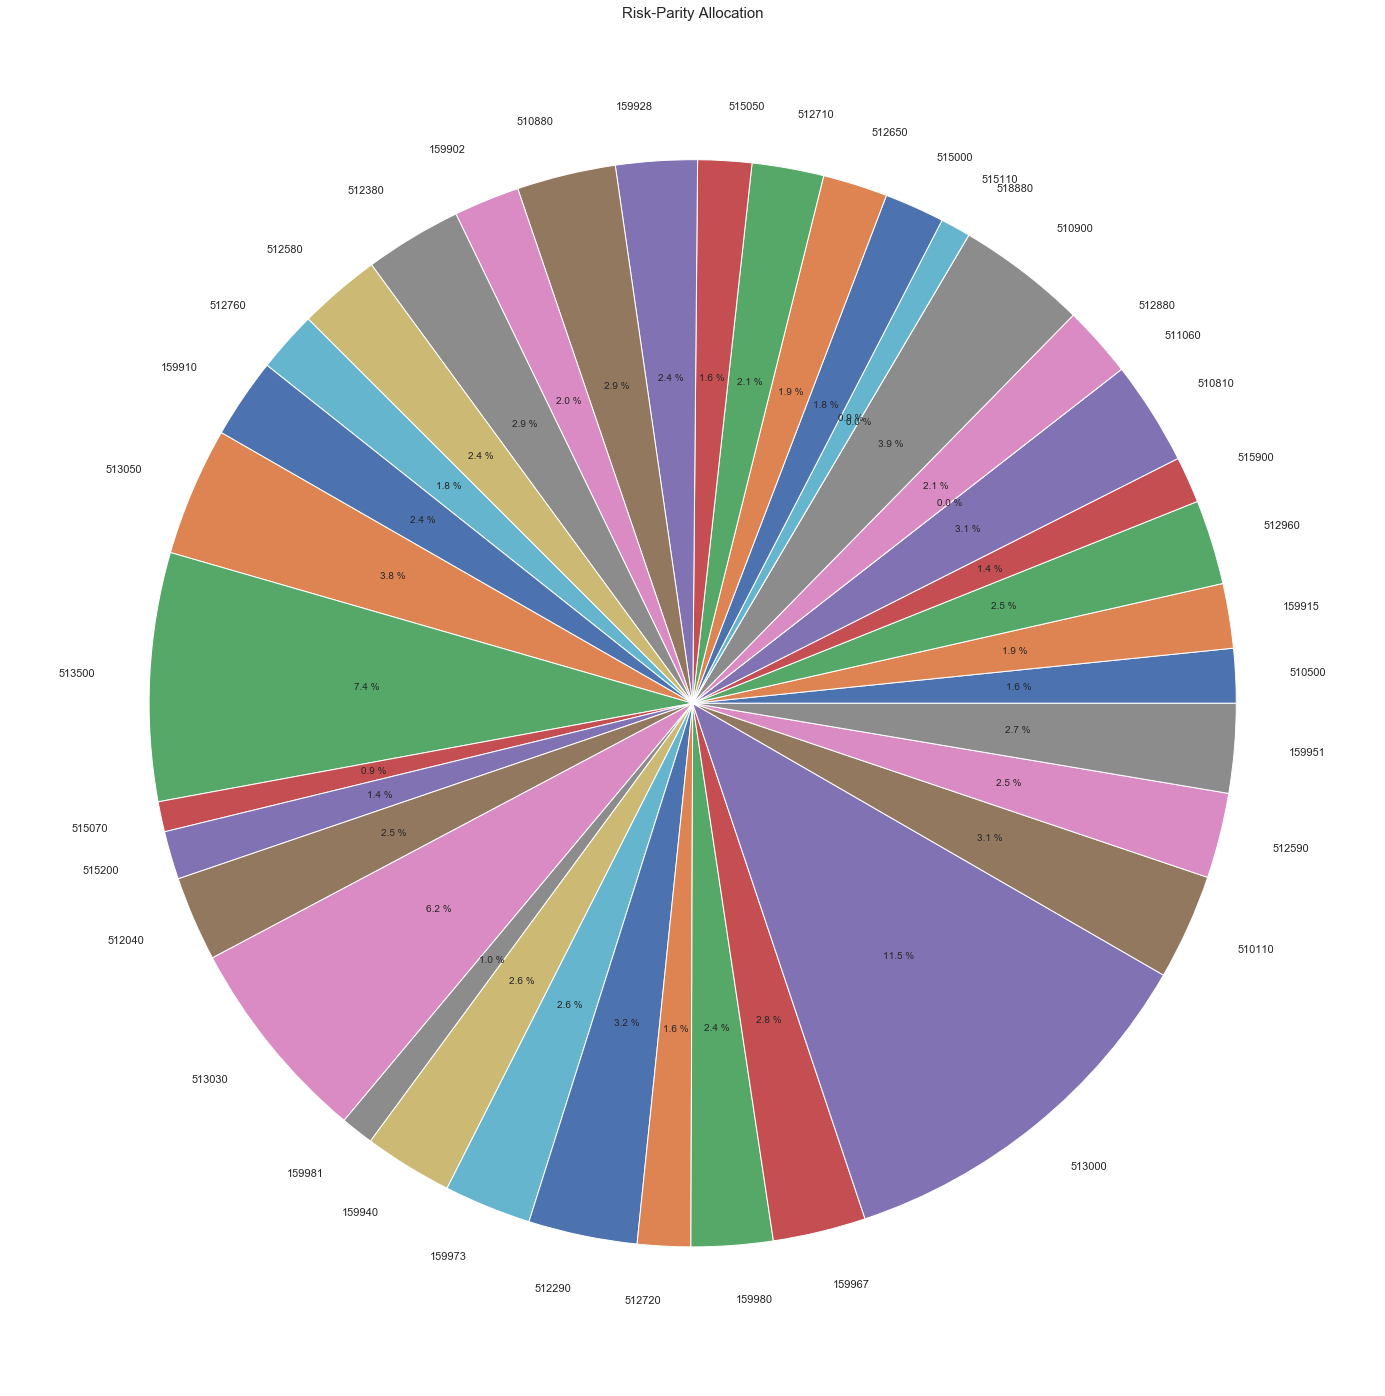

In [12]:
draw_risk_parity_pie(weights, etfs)

In [16]:
# match the weights of each ETF

signal_df['code'] = signal_df['code'].astype(str)
signal_df['WEIGHT'] = ""

for i, code_wts in enumerate(df_wts['ETF']):
    for j, code_signal in enumerate(signal_df['code']):
        if code_wts == code_signal:
            signal_df['WEIGHT'].values[j]=df_wts['Portfolio_Weight'].values[i]
            
# create the most recent trading date
last_date = signal_df['date'].values[0]

# get the close data for these tickers
signal_df_etfs = list(signal_df['code'].unique())
signal_df_closes = get_date_price_code_df(etf_path, signal_df_etfs, 'date', 'close', 'code')

# filter the data by the most recent trading date
last_date_signal_df_closes = signal_df_closes[signal_df_closes['date']==last_date]

# merge with signal_df to get the closes so that target shares can be calculated later
signal_df_final = last_date_signal_df_closes.merge(signal_df, on = ['date','code'], how = 'outer')

# clean those without numbers in the WEIGHT columns
signal_df_final['WEIGHT'] = signal_df_final['WEIGHT'].apply(lambda x: 0 if x=="" else x)

# calculate target shares
account_values = 200000
signal_df_final['TARGET_SHARES'] = (signal_df_final['WEIGHT']*account_values)/signal_df_final['close']

# filter to get those with potential trading actions needed
condition_of_action = (signal_df_final['SIGNAL_ACTION_x']=="LONG")|(signal_df_final['SIGNAL_ACTION_x']=="SHORT")|\
                    (signal_df_final['SIGNAL_ACTION_y']=="LONG")|(signal_df_final['SIGNAL_ACTION_y']=="SHORT")
df_actions = signal_df_final[condition_of_action]

In [17]:
signal_df

,date,code,SIGNAL_STATUS_x,SIGNAL_ACTION_x,TYPE_x,SIGNAL_STATUS_y,SIGNAL_ACTION_y,TYPE_y,WEIGHT
0,2020-03-05,159916,多头状态,NO CHANGE,CUR_POS,NaN,NaN,NaN,
1,2020-03-05,159933,多头状态,NO CHANGE,CUR_POS,NaN,NaN,NaN,
2,2020-03-05,510090,多头状态,NO CHANGE,CUR_POS,NaN,NaN,NaN,
3,2020-03-05,510110,多头状态,NO CHANGE,CUR_POS,多头状态,NO CHANGE,TARGET,0.0314719
4,2020-03-05,510270,多头状态,NO CHANGE,CUR_POS,NaN,NaN,NaN,
5,2020-03-05,511030,多头状态,NO CHANGE,CUR_POS,多头状态,NO CHANGE,TARGET,
6,2020-03-05,512590,多头状态,NO CHANGE,CUR_POS,多头状态,NO CHANGE,TARGET,0.0253613
7,2020-03-05,159902,NaN,NaN,NaN,空头状态,NO CHANGE,TARGET,0.0195647
8,2020-03-05,159910,NaN,NaN,NaN,多头状态,NO CHANGE,TARGET,0.0238549
9,2020-03-05,159915,NaN,NaN,NaN,空头状态,NO CHANGE,TARGET,0.0192054


In [31]:
df_actions

,date,close,code,SIGNAL_STATUS_x,SIGNAL_ACTION_x,TYPE_x,SIGNAL_STATUS_y,SIGNAL_ACTION_y,TYPE_y,WEIGHT,TARGET_SHARES
14,2020-03-05,1.283,159973,NaN,NaN,NaN,多头状态,LONG,TARGET,0.025934,4042.787548


In [18]:
# Save data
signal_df_final.to_csv("signal_df_final.csv", mode='a', header=False)
df_actions.to_csv("df_actions.csv", mode='a', header=False)

# Evaluate performances

In [20]:
def create_sharpe_ratio(returns, periods=252):
    print("*****performance.py: 1. create_sharpe_ratio*****")
    """
    Create the Sharpe ratio for the strategy, based on a 
    benchmark of zero (i.e. no risk-free rate information).
    Parameters:
    returns - A pandas Series representing period percentage returns.
    periods - Daily (252), Hourly (252*6.5), Minutely(252*6.5*60) etc.
    """
    return np.sqrt(periods) * (np.mean(returns)) / np.std(returns)

def create_drawdowns(pnl):
    print("*****performance.py: 2. create_drawdowns*****")
    """
    Calculate the largest peak-to-trough drawdown of the PnL curve
    as well as the duration of the drawdown. Requires that the 
    pnl_returns is a pandas Series.
    Parameters:
    pnl - A pandas Series representing period percentage returns.
    Returns:
    drawdown, duration - Highest peak-to-trough drawdown and duration.
    """

    # Calculate the cumulative returns curve 
    # and set up the High Water Mark
    hwm = [0]

    # Create the drawdown and duration series
    idx = pnl.index
    drawdown = pd.Series(index = idx)
    duration = pd.Series(index = idx)

    # Loop over the index range
    for t in range(1, len(idx)):
        hwm.append(max(hwm[t-1], pnl[t]))
        drawdown[t]= (hwm[t]-pnl[t])
        duration[t]= (0 if drawdown[t] == 0 else duration[t-1]+1)
    return drawdown, drawdown.max(), duration.max()

def create_expected_annual_returns(pnl, periods=252):
    traded_days = len(pnl)
    last_pnl = pnl.values[-1]
    annual_returns = (1+last_pnl)**(periods/traded_days)-1
    return annual_returns

def create_total_returns(pnl):
    return pnl.values[-1]

In [21]:
def linreg(x, y):
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y, x).fit()
    x = x[:,1]
    return model.params[0], model.params[1]


def benchmkt_strat(csv_path):
    sh_index = pd.read_csv(etf_path+"sh000001.csv")
    sh_index['pct_chg'] = sh_index['close'].pct_change()
    sh_index_2020 = sh_index[sh_index['trade_date']>='2020-01-02']
    sh_index_2020['adjusted_pct_chg'] = sh_index_2020['pct_chg']
    sh_index_2020['adjusted_pct_chg'].values[0] = 0
    sh_index_2020['cum_sum_pct_chg'] = sh_index_2020['adjusted_pct_chg'].cumsum()+1

    track_record = pd.DataFrame()
    track_record['date'] = date # date list
    track_record['sbtv1'] = sbtv1 # strat's equity curve values, baseline is 1
    track_record['sh_mkt'] = sh_index_2020['cum_sum_pct_chg'].values
    track_record.index = pd.to_datetime(track_record['date'])
    del track_record['date']

    track_record['returns0'] = track_record['sbtv1'].diff()
    track_record['returns0'].values[0] = 0
    track_record['returns1'] = track_record['sh_mkt'].diff()
    track_record['returns1'].values[0] = 0
    
    X = track_record['returns1'].values
    Y = track_record['returns0'].values
    
    return track_record, sh_index, X, Y

In [22]:
track_record, sh_index, X, Y = benchmkt_strat(etf_path)
last_date = sh_index['trade_date'].values[-1]

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [23]:
def print_performances(track_record, last_date, alpha, beta):
    sharpe_ratio0 = create_sharpe_ratio(track_record['returns0'], periods=252)
    sharpe_ratio1 = create_sharpe_ratio(track_record['returns1'], periods=252)
    drawdown0, max_drawdown0, max_dd_duration0 = create_drawdowns(track_record['sbtv1'])
    drawdown1, max_drawdown1, max_dd_duration1 = create_drawdowns(track_record['sh_mkt'])
    annual_returns0 = create_expected_annual_returns(track_record['sbtv1']-1)
    annual_returns1 = create_expected_annual_returns(track_record['sh_mkt']-1)
    total_returns0 = create_total_returns(track_record['sbtv1']-1)
    total_returns1 = create_total_returns(track_record['sh_mkt']-1)
    corr_returns0_1 = track_record['returns0'].corr(track_record['returns1'])
    print("=========================SBTV1策略=======================")
    print("\n")
    print("SBTV1策略 - 开始时间：2020-01-02")
    print("SBTV1策略 - 当前时间：{}".format(last_date))
    print("SBTV1策略 - 实时 绝对收益：", round(total_returns0*100, 2), "%")
    print("SBTV1策略 - 实时 夏普比率：", round(sharpe_ratio0, 2))
    print("SBTV1策略 - 实时 期望年化收益率：", round(annual_returns0*100, 2),"%")
    print("SBTV1策略 - 实时 最大回撤比率：", round(max_drawdown0*100,2), "%")
    print("SBTV1策略 - 实时 最大回撤持续时间：", int(max_dd_duration0), "天")
    print("SBTV1策略 - 实时 Beta：", round(beta, 4))
    print("SBTV1策略 - 实时 超额收益Alpha：", round(total_returns0-total_returns1, 4))
    print("SBTV1策略 - 实时 风险调整Alpha：", round(alpha, 6))
    print("\n")
    print("=========================上证指数=======================")
    print("\n")
    print("上证指数 - 开始时间：2020-01-02")
    print("上证指数 - 当前时间：{}".format(last_date))
    print("上证指数 - 实时 绝对收益：", round(total_returns1*100,2), "%")
    print("上证指数 - 实时 夏普比率：", round(sharpe_ratio1, 2))
    print("上证指数 - 实时 最大回撤比率：", round(max_drawdown1*100,2), "%")
    print("上证指数 - 实时 最大回撤持续时间：", int(max_dd_duration1), "天")

In [24]:
def linreg(x, y):
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y, x).fit()
    
    x = x[:,1]
    return model.params[0], model.params[1]

alpha, beta = linreg(X,Y)

In [25]:
print_performances(track_record, last_date, alpha, beta)

*****performance.py: 1. create_sharpe_ratio*****
*****performance.py: 1. create_sharpe_ratio*****
*****performance.py: 2. create_drawdowns*****
*****performance.py: 2. create_drawdowns*****
=========================SBTV1策略=======================


SBTV1策略 - 开始时间：2020-01-02
SBTV1策略 - 当前时间：2020-03-05
SBTV1策略 - 实时 绝对收益： 1.09 %
SBTV1策略 - 实时 夏普比率： 2.18
SBTV1策略 - 实时 期望年化收益率： 7.08 %
SBTV1策略 - 实时 最大回撤比率： 1.15 %
SBTV1策略 - 实时 最大回撤持续时间： 9 天
SBTV1策略 - 实时 Beta： 0.0112
SBTV1策略 - 实时 超额收益Alpha： 0.0091
SBTV1策略 - 实时 风险调整Alpha： 0.000272


=========================上证指数=======================


上证指数 - 开始时间：2020-01-02
上证指数 - 当前时间：2020-03-05
上证指数 - 实时 绝对收益： 0.18 %
上证指数 - 实时 夏普比率： 0.04
上证指数 - 实时 最大回撤比率： 12.24 %
上证指数 - 实时 最大回撤持续时间： 32 天


In [29]:
my_strat_plot = go.Scatter(
    x = track_record.index,
    y = track_record['sbtv1'],
    name = 'SBTV1策略累计收益率'
)
 
    
mkt_plot = go.Scatter(
    x = track_record.index,
    y = track_record['sh_mkt'],
    name = '上证指数累积收益率'
)
    
layout = dict(title = 'SBTV1策略累计收益率',
              xaxis = dict(title = '时间'), # 横轴坐标
              yaxis = dict(title = '收益率'), # 总轴坐标
              legend=dict(x=1.1,y=1) # 图例位置 
              )

data = [my_strat_plot, mkt_plot]

fig = dict(data=data, layout=layout)

py.iplot(fig)

# Start summarizing packages

## 1. Risk Parity Package

In [ ]:
def risk_partity_allocation(path, tickers):
    